In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2020],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:42825 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 237 ms, sys: 14.6 ms, total: 252 ms
Wall time: 242 ms


# 2020 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2020,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

In [8]:
data[config_year.year]

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,year_last_updated_date,month_last_updated_date,week_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date
npartitions=12,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Preprocessing

In [9]:
%%time

# do not execute everytime, takes 17s and eat the memory. Once executed disable the cell and restart the notebook. Since this cell saves a checkpoint you can continue without it.

data[config_year.year] = data[config_year.year].drop(['week_last_updated_date', 'last_reported'], axis=1)

data[config_year.year]['station_id']=data[config_year.year]['station_id'].astype(int)
data[config_year.year]['is_charging_station']=data[config_year.year]['is_charging_station'].astype(int)
data[config_year.year]['last_updated']=data[config_year.year]['last_updated'].astype(int)
data[config_year.year]['year_last_updated_date']=data[config_year.year]['year_last_updated_date'].astype(int)
data[config_year.year]['month_last_updated_date']=data[config_year.year]['month_last_updated_date'].astype(int)
data[config_year.year]['dayofweek_last_updated_date']=data[config_year.year]['dayofweek_last_updated_date'].astype(int)
data[config_year.year]['dayofmonth_last_updated_date']=data[config_year.year]['dayofmonth_last_updated_date'].astype(int)
data[config_year.year]['dayofyear_last_updated_date']=data[config_year.year]['dayofyear_last_updated_date'].astype(int)
data[config_year.year]['hour_last_updated_date']=data[config_year.year]['hour_last_updated_date'].astype(int)

data[config_year.year]['status']=data[config_year.year]['status'].round().astype(int)
data[config_year.year]['is_installed']=data[config_year.year]['is_installed'].round().astype(int)
data[config_year.year]['is_renting']=data[config_year.year]['is_renting'].round().astype(int)
data[config_year.year]['is_returning']=data[config_year.year]['is_returning'].round().astype(int)

# Found two station with alot of missing values 
# best solution is to remove
# condition = (data[config_year.year]['station_id'].isin([520.0, 527.0, 532.0]))
# data[config_year.year] = data[config_year.year].mask(condition, np.nan)
# data[config_year.year] = data[config_year.year].dropna(subset=['station_id'])

last_size = get_ddf_shape(data[config_year.year])

new_columns = {
    'last_updated': 'timestamp',
    'year_last_updated_date':'year', 
    'month_last_updated_date':'month',
    'dayofweek_last_updated_date':'dayofweek', 
    'dayofmonth_last_updated_date':'day', 
    'dayofyear_last_updated_date':'dayofyear',
    'hour_last_updated_date':'hour'
}

data[config_year.year] = data[config_year.year].rename(columns=new_columns)

CPU times: user 1.06 s, sys: 40.1 ms, total: 1.1 s
Wall time: 2.53 s


In [10]:
save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.
# CPU times: user 2.12 s, sys: 250 ms, total: 2.37 s
# Wall time: 17.3 s

checkpoint saved.


In [11]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 12.8 ms


In [12]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 00 rows
dropped -2 columns
CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 754 ms


In [13]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [14]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 612 ms, sys: 0 ns, total: 612 ms
Wall time: 3.34 s


In [15]:
nans

{}

In [16]:
zeros

{'num_bikes_available': 4.216873868922792,
 'num_bikes_available_types.mechanical': 10.9436000248229,
 'num_bikes_available_types.ebike': 34.74171605622275,
 'num_docks_available': 0.9711959326226007,
 'is_installed': 0.015821802891644133,
 'is_renting': 0.6036045756877593,
 'is_returning': 0.5915006169384979,
 'is_charging_station': 0.0010622411835379453,
 'status': 99.41020455969823,
 'dayofweek': 14.429987404055861,
 'hour': 4.134494269767889}

In [17]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [18]:
uniques

{'station_id': 0        1
 1      301
 2      300
 3      299
 4       14
       ... 
 513    452
 514    450
 515    465
 516    502
 517    503
 Name: station_id, Length: 518, dtype: int64,
 'num_bikes_available': 0       21.555556
 1       23.333333
 2       26.000000
 3       28.181818
 4       31.000000
           ...    
 4290    29.277778
 4291    24.150000
 4292    33.850000
 4293    29.227273
 4294     2.136364
 Name: num_bikes_available, Length: 4295, dtype: float64,
 'num_bikes_available_types.mechanical': 0       21.444444
 1       23.333333
 2       24.222222
 3       26.272727
 4       29.000000
           ...    
 3905    29.277778
 3906     6.045455
 3907    36.583333
 3908    33.850000
 3909    29.227273
 Name: num_bikes_available_types.mechanical, Length: 3910, dtype: float64,
 'num_bikes_available_types.ebike': 0        0.111111
 1        0.000000
 2        1.777778
 3        1.909091
 4        2.000000
           ...    
 1739     1.128205
 1740     1.772727
 1741  

### Finding max capacity for a station

In [19]:
%%time

print(stats.describe(data[config_year.year].num_docks_available))
data[config_year.year].num_docks_available.describe().compute()

DescribeResult(nobs=3577342, minmax=(0.0, 99.0), mean=15.59941622044943, variance=68.89294206728536, skewness=0.16072792374272846, kurtosis=-0.05906262430613074)
CPU times: user 487 ms, sys: 87.4 ms, total: 574 ms
Wall time: 1.76 s


count    3.577342e+06
mean     1.559942e+01
std      8.300177e+00
min      0.000000e+00
25%      1.175000e+01
50%      1.716667e+01
75%      2.370000e+01
max      9.900000e+01
Name: num_docks_available, dtype: float64

In [20]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=3577342, minmax=(0.0, 198.0), mean=9.86227603908363, variance=65.22287319127761, skewness=0.9286648130104065, kurtosis=2.6688369379609744)
CPU times: user 499 ms, sys: 114 ms, total: 613 ms
Wall time: 1.8 s


count    3.577342e+06
mean     9.862276e+00
std      8.076068e+00
min      0.000000e+00
25%      4.125000e+00
50%      1.150000e+01
75%      1.757143e+01
max      1.980000e+02
Name: num_bikes_available, dtype: float64

In [21]:
%%time

print(stats.describe(data[config_year.year]['num_bikes_available_types.mechanical']))
data[config_year.year]['num_bikes_available_types.mechanical'].describe().compute()

DescribeResult(nobs=3577342, minmax=(0.0, 99.0), mean=8.683635324188378, variance=63.37567171246116, skewness=0.9466507555906466, kurtosis=0.8083106329111462)
CPU times: user 500 ms, sys: 72.9 ms, total: 573 ms
Wall time: 1.77 s


count    3.577342e+06
mean     8.683635e+00
std      7.960884e+00
min      0.000000e+00
25%      3.500000e+00
50%      1.000000e+01
75%      1.575000e+01
max      9.900000e+01
Name: num_bikes_available_types.mechanical, dtype: float64

In [22]:
print(stats.describe(data[config_year.year]['num_bikes_available_types.ebike']))
data[config_year.year]['num_bikes_available_types.ebike'].describe().compute()

DescribeResult(nobs=3577342, minmax=(0.0, 99.0), mean=1.2464867155539818, variance=4.444518193605925, skewness=3.9549346950427444, kurtosis=48.73059560778481)


count    3.577342e+06
mean     1.246487e+00
std      2.108203e+00
min      0.000000e+00
25%      0.000000e+00
50%      8.750000e-01
75%      3.000000e+00
max      9.900000e+01
Name: num_bikes_available_types.ebike, dtype: float64

correct data 3552090 incorrect data 25252
CPU times: user 1.4 s, sys: 254 ms, total: 1.65 s
Wall time: 5.33 s


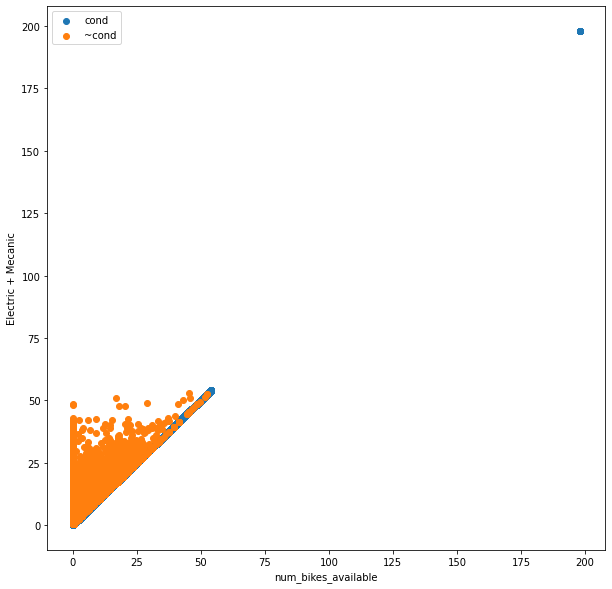

In [23]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())
    
plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [24]:
%%time

data[config_year.year]['num_bikes_available'] = data[config_year.year]['num_bikes_available'].mask(~cond, (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']))


CPU times: user 0 ns, sys: 8.91 ms, total: 8.91 ms
Wall time: 8.22 ms


correct data 3577342 incorrect data 0
CPU times: user 1.7 s, sys: 237 ms, total: 1.94 s
Wall time: 5.8 s


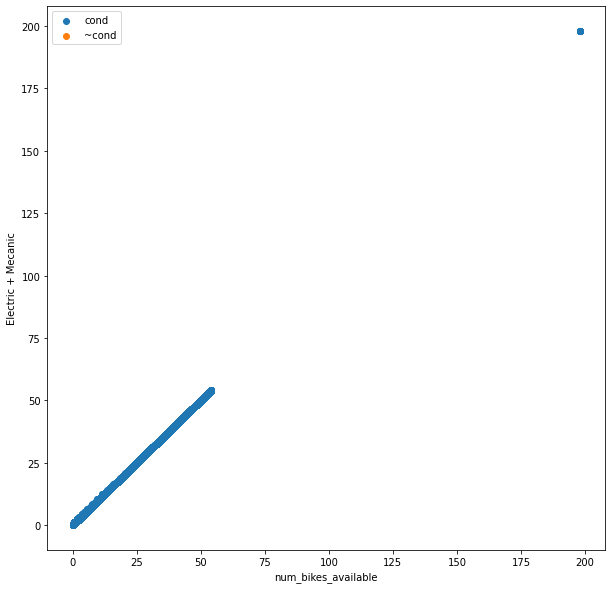

In [25]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())

plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [26]:
# Now capacity of a station must be something similar to the sum of available bikes and available docks

In [27]:
%%time

data[config_year.year]['capacity'] = data[config_year.year].num_bikes_available + data[config_year.year].num_docks_available

stations_max_capacity = data[config_year.year].groupby(['station_id'])['capacity'].max().reset_index()

# drop capacity 
data[config_year.year] = data[config_year.year].drop(['capacity'], axis=1)

# merge with stations_max_capacity
data[config_year.year] = data[config_year.year].merge(stations_max_capacity.copy(), how='left', on=['station_id'])


CPU times: user 15.8 ms, sys: 9.04 ms, total: 24.9 ms
Wall time: 24 ms


In [28]:
%%time

print(stats.describe(data[config_year.year]['capacity']))
data[config_year.year]['capacity'].describe().compute()

DescribeResult(nobs=3577342, minmax=(0.0, 297.0), mean=27.16683455984757, variance=38.00601660582682, skewness=1.8349043472272426, kurtosis=30.031786822942713)
CPU times: user 720 ms, sys: 78.6 ms, total: 798 ms
Wall time: 2.56 s


count    3.577342e+06
mean     2.716683e+01
std      6.164902e+00
min      0.000000e+00
25%      2.400000e+01
50%      2.700000e+01
75%      3.100000e+01
max      2.970000e+02
Name: capacity, dtype: float64

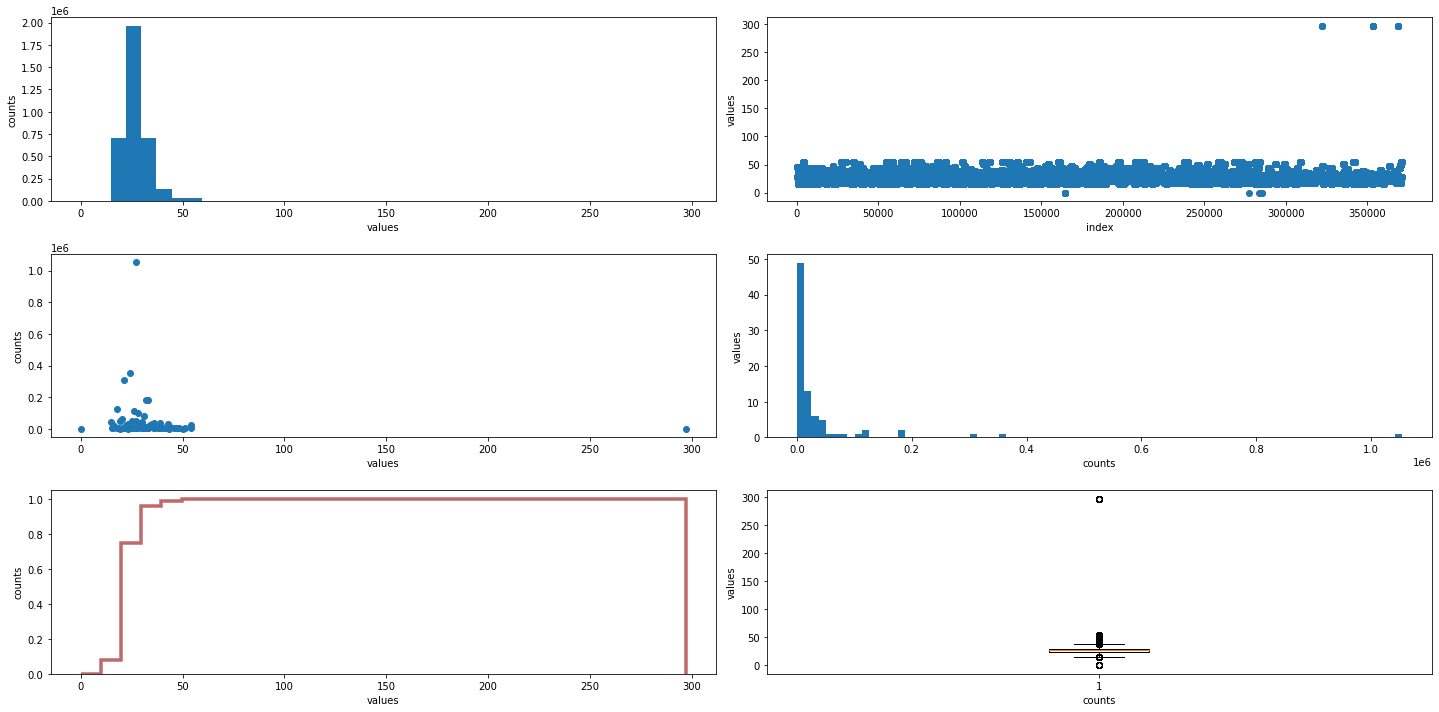

CPU times: user 6.1 s, sys: 1.01 s, total: 7.11 s
Wall time: 6.7 s


In [29]:
%%time

show_counts(data[config_year.year]['capacity'].compute())

## find the percentage of docks available

In [30]:
%%time

data[config_year.year]['ctx0'] = data[config_year.year].num_docks_available / data[config_year.year].capacity


CPU times: user 0 ns, sys: 8.36 ms, total: 8.36 ms
Wall time: 7.71 ms


In [31]:
%%time

print(stats.describe(data[config_year.year]['ctx0']))
data[config_year.year]['ctx0'].describe().compute()

DescribeResult(nobs=3577342, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
CPU times: user 689 ms, sys: 107 ms, total: 796 ms
Wall time: 2.62 s


count    3.577330e+06
mean     5.763826e-01
std      2.801157e-01
min      0.000000e+00
25%      4.640000e-01
50%      6.666667e-01
75%      8.750000e-01
max      1.000000e+00
Name: ctx0, dtype: float64

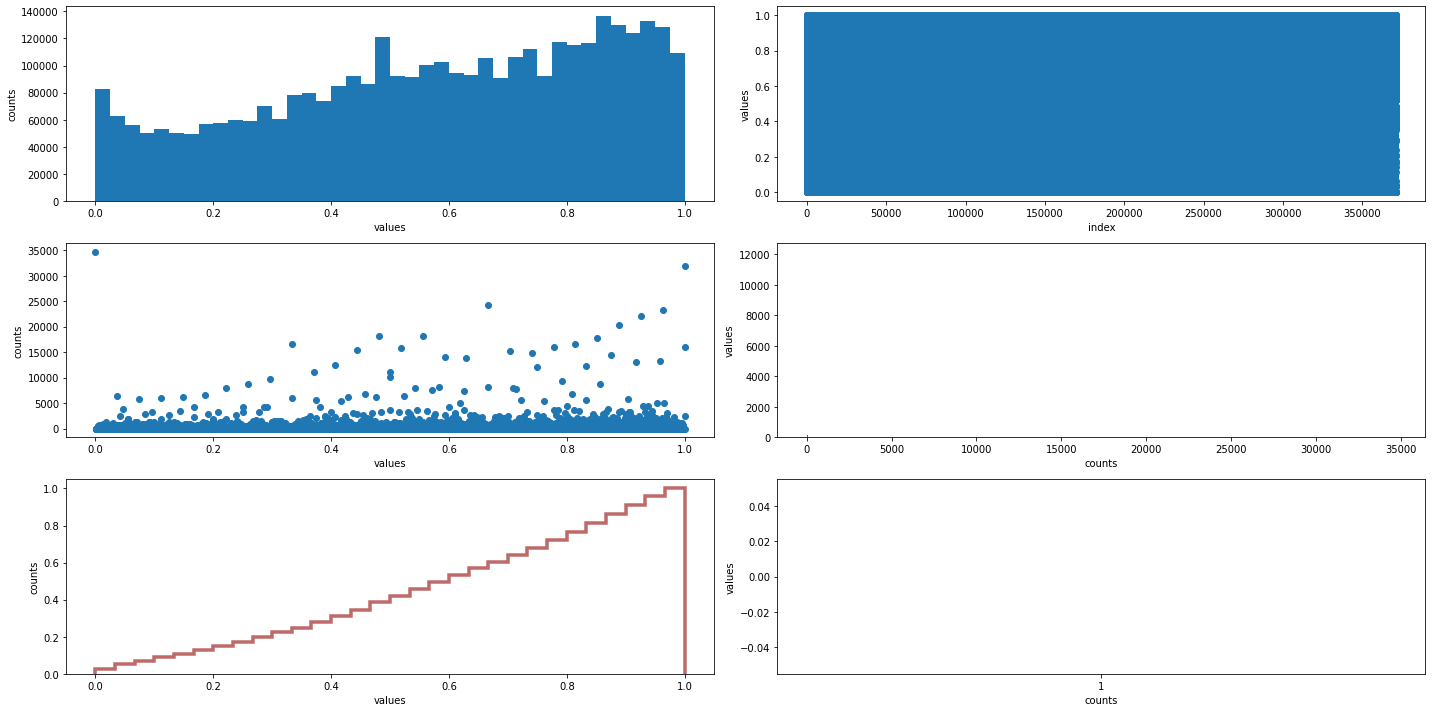

CPU times: user 1min 49s, sys: 21.3 s, total: 2min 10s
Wall time: 2min 7s


In [32]:
%%time

show_counts(data[config_year.year]['ctx0'].compute())

### Generating new columns of past 4 hours

In [33]:
%%time

ctx = data[config_year.year][['station_id', 'timestamp', 'ctx0']].copy()
# ctx = ctx.rename(columns={'num_docks_available': 'ctx0'})
print(ctx.columns)

for i in range(1,5): 
    ctx = ctx.rename(columns={f'ctx{i-1}': f'ctx{i}'})
    print(ctx.columns)
    
    ctx.timestamp = ctx.timestamp + 3600 
    data[config_year.year] = data[config_year.year].merge(ctx.copy(), how='left', on=['station_id','timestamp'])
    
    cond = data[config_year.year][f'ctx{i}'].isna()
    data[config_year.year][f'ctx{i}'] = data[config_year.year][f'ctx{i}'].mask(cond, data[config_year.year][f'ctx{i-1}'])


Index(['station_id', 'timestamp', 'ctx0'], dtype='object')
Index(['station_id', 'timestamp', 'ctx1'], dtype='object')
Index(['station_id', 'timestamp', 'ctx2'], dtype='object')
Index(['station_id', 'timestamp', 'ctx3'], dtype='object')
Index(['station_id', 'timestamp', 'ctx4'], dtype='object')
CPU times: user 152 ms, sys: 19.8 ms, total: 172 ms
Wall time: 167 ms


In [34]:
data[config_year.year].columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
       'status', 'timestamp', 'year', 'month', 'dayofweek', 'day', 'dayofyear',
       'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4'],
      dtype='object')

In [35]:
%%time

get_features_nans(data[config_year.year])

CPU times: user 10.9 s, sys: 369 ms, total: 11.2 s
Wall time: 20.6 s


{'ctx0': 0.0003354445842751406,
 'ctx1': 0.0003354445842751406,
 'ctx2': 0.0003354445842751406,
 'ctx3': 0.0003354445842751406,
 'ctx4': 0.0003354445842751406}

In [36]:
%%time

save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.

checkpoint saved.
CPU times: user 3.16 s, sys: 259 ms, total: 3.42 s
Wall time: 25.2 s
